In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from Models.VGG import VGG16

In [3]:
import Utils.Dataset as ds
import Utils.utils as utils

In [4]:
image_classes_paths, classes = utils.get_classes_and_paths()
print(f'Image Classes Paths: {image_classes_paths}\nClasses: {classes}')

Image Classes Paths: ['/Users/Andrew/ml/ImageRecognitionOOTB/Data/TrainImages/LilUziVert', '/Users/Andrew/ml/ImageRecognitionOOTB/Data/TrainImages/Kanye', '/Users/Andrew/ml/ImageRecognitionOOTB/Data/TrainImages/TravisScott']
Classes: ['LilUziVert', 'Kanye', 'TravisScott']


In [5]:
train_indices = []
test_indices = []

for i_class in image_classes_paths:
    
    class_len = len(os.listdir(i_class))
    
    train, val, test = \
        utils.get_indices(class_len, train_percent=0.8, val_percent=0.0, test_percent=0.2)
    
    train_indices.append(train)
    test_indices.append(test)

print(train_indices)
print(test_indices)

[array([0, 1, 3, 4, 5, 6, 8]), array([0, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 6, 8])]
[array([2, 7]), array([1, 8]), array([5, 7])]


In [6]:
train_set = ds.DataSetCreator(image_classes_paths, train_indices)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(train_loader)

In [7]:
test_set = ds.DataSetCreator(image_classes_paths, test_indices, augment=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)

In [8]:
data_loaders = {'train': train_loader, 'test': test_loader}
print(len(train_loader.dataset))
print(len(test_loader))

21
2


In [9]:
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


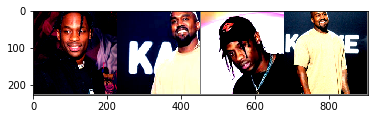

TravisScott Kanye TravisScott Kanye


In [10]:
utils.show_image(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[int(labels[j].item())] for j in range(4)))

In [11]:
net = VGG16(len(classes), data_loaders)
print(net.net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [12]:
for name, param in net.net.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.1.weight False
features.1.bias False
features.3.weight False
features.3.bias False
features.4.weight False
features.4.bias False
features.7.weight False
features.7.bias False
features.8.weight False
features.8.bias False
features.10.weight False
features.10.bias False
features.11.weight False
features.11.bias False
features.14.weight False
features.14.bias False
features.15.weight False
features.15.bias False
features.17.weight False
features.17.bias False
features.18.weight False
features.18.bias False
features.20.weight False
features.20.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.25.weight False
features.25.bias False
features.27.weight False
features.27.bias False
features.28.weight False
features.28.bias False
features.30.weight False
features.30.bias False
features.31.weight False
features.31.bias False
features.34.weight True
features.34.bias True
featur

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
net.to(device)

if torch.cuda.is_available():
    net.net = torch.nn.DataParallel(net.net)
    criterion = nn.CrossEntropyLoss().cuda()
    dtype = torch.cuda.FloatTensor

else:
    criterion = nn.CrossEntropyLoss()
    dtype = torch.FloatTensor

optimizer = optim.Adam(filter(lambda p: p.requires_grad, net.net.parameters()))

In [15]:
outputs = net.single_test(images)
print(outputs)

tensor([[ 0.0682, -0.1424, -0.3136],
        [-0.0935,  0.3719,  0.0719],
        [ 0.1719, -0.0227,  0.0764],
        [ 0.2348,  0.0559, -0.2726]], grad_fn=<ThAddmmBackward>)


# Error w/ loss

In [16]:
net.train(criterion, optimizer, num_epochs=5)


Epoch: 1/5
TRAIN
Percent: [██████████████████████████████ 100.0% 6/6] Loss: 2.0381436461494085, Accuracy: 0.42857142857142855
TEST
Percent: [██████████████████████████████ 100.0% 2/2] Loss: 1.9875389734903972, Accuracy: 0.6666666666666666

Epoch: 2/5
TRAIN
Percent: [██████████████████████████████ 100.0% 6/6] Loss: 0.6623042821884155, Accuracy: 0.7142857142857143
TEST
Percent: [██████████████████████████████ 100.0% 2/2] Loss: 4.656148592631022, Accuracy: 0.6666666666666666

Epoch: 3/5
TRAIN
Percent: [██████████████████████████████ 100.0% 6/6] Loss: 0.6874013883726937, Accuracy: 0.7619047619047619
TEST
Percent: [██████████████████████████████ 100.0% 2/2] Loss: 0.10722086826960246, Accuracy: 1.0

Epoch: 4/5
TRAIN
Percent: [██████████████████████████████ 100.0% 6/6] Loss: 0.5142583960578555, Accuracy: 0.8095238095238095
TEST
Percent: [██████████████████████████████ 100.0% 2/2] Loss: 2.0544690787792206, Accuracy: 0.8333333333333334

Epoch: 5/5
TRAIN
Percent: [██████████████████████████████

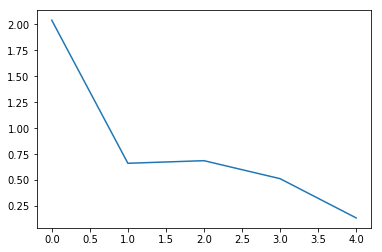

In [17]:
plt.plot(net.train_loss_history)

# Debugging

In [49]:
run_loss = 0.0
run_corrects = 0
inputs_total = 0
total = 0

for index, (inputs, targets) in enumerate(data_loaders['train']):
    
    print(index)
    
    with torch.set_grad_enabled(True):
        outputs = net.net(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, targets)
    
    run_loss += loss.item() * inputs.size(0)
    run_corrects += preds.eq(targets).sum().item()
    total += targets.size(0)
    inputs_total += inputs.size(0)


0
1
2
3
4
5


In [50]:
print(f'Inputs Total: {inputs_total}, Total: {total}, Loss: {run_loss}')

Inputs Total: 21, Total: 21, Loss: 24.7510786652565


In [51]:
run_loss = 0.0
run_corrects = 0
inputs_total = 0
total = 0

for index, (inputs, targets) in enumerate(data_loaders['test']):
    
    print(index)
    
    outputs = net.net(inputs)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, targets)
    
    run_loss += loss.item() * inputs.size(0)
    run_corrects += preds.eq(targets).sum().item()
    total += targets.size(0)
    inputs_total += inputs.size(0)


0
1


In [52]:
print(f'Inputs Total: {inputs_total}, Total: {total}, Loss: {run_loss}')

Inputs Total: 6, Total: 6, Loss: 7.092169284820557
